#### Purpose of this kernel

- Kernel illustrates final solution for the quora case 
- Kernel is run on GPU with Cuda/CuDNN to accelerate Model training

#### Import libraries

In [1]:
%%capture --no-stdout

# General
import pandas as pd
import numpy as np
import os
import gc # Garbage Collection to delete references and instances which are not needed anymore (Memory Management)
import sys
import time # To monitor execution time of different code sections

# Preprocessing
import seaborn as sns
import re
from re import *
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from gensim.models import KeyedVectors
import nltk
from nltk.stem import PorterStemmer
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem import SnowballStemmer 
from nltk import pos_tag, word_tokenize
from nltk.corpus import wordnet as wn
lemmatizer = nltk.WordNetLemmatizer() # lemmatizer checks english word net

# Modeling
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense
from keras.layers import SimpleRNN, GRU, Bidirectional, LSTM,CuDNNLSTM, CuDNNGRU
from keras.layers import SpatialDropout1D
from keras.layers.pooling import GlobalMaxPooling1D
from keras import backend

# Training
# from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit

# Evaluation
from keras.callbacks import Callback
from sklearn.metrics import f1_score, precision_score, recall_score
import matplotlib.pyplot as plt

In [2]:
# check status and availability of GPU
print("GPU on?  - ", tf.test.is_gpu_available())
print("Available GPUs: ", tf.test.gpu_device_name())

# confirm Keras sees the GPU
assert len(backend.tensorflow_backend._get_available_gpus()) > 0 # test if Keras sees GPU, if not trigger an error 

GPU on?  -  True
Available GPUs:  /device:GPU:0


In [3]:
# inspect available files in workspacce
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/quora-insincere-questions-classification/train.csv
/kaggle/input/quora-insincere-questions-classification/sample_submission.csv
/kaggle/input/quora-insincere-questions-classification/test.csv
/kaggle/input/quora-insincere-questions-classification/embeddings/paragram_300_sl999/paragram_300_sl999.txt
/kaggle/input/quora-insincere-questions-classification/embeddings/paragram_300_sl999/README.txt
/kaggle/input/quora-insincere-questions-classification/embeddings/wiki-news-300d-1M/wiki-news-300d-1M.vec
/kaggle/input/quora-insincere-questions-classification/embeddings/GoogleNews-vectors-negative300/GoogleNews-vectors-negative300.bin
/kaggle/input/quora-insincere-questions-classification/embeddings/glove.840B.300d/glove.840B.300d.txt


#### Hyperparameters

* used to control code behaviour during Data Preparation and Model Training

In [4]:
# Define number of samples to use within this script
# total_train_samples = 30000 # used if script is executed in development mode (train with reduced sample size)
total_train_samples = 1306122 # use all samples in training set

# Data Preparation
maxlen = 130 # 130 - covers about 75% of all bad questions completely
max_words = 9999999 # dummy to use all words within word_index (=vocabulary derived from questions)

# Training
model_epochs = 10 # number of epochs the model is trained 

# Evaluation with Cross Validation
"""
State-of-the-Art to evaluate a model is Cross-validation with k = 5 or k = 10.
However this would exceed the maximum allowed kernel runtime.
Since results are quite stable across different k, it was decided to use k = 3 to evaluate model performnace.
k = 3 poses a good tradeoff between runtime and meaningful evaluation
"""
kfolds = 3 # perform StratifiedShuffleSplit with k = 3

# Data Preparation

* 1 - This section contains the preprocessing function and corresponding mapping dictionaries
* 2 - This section contains the my_tokenizer function
* 3 - This sections contains the functions to create the embedding matrix
* 4 - This section contains the execution of all data processing steps

### 1. Definition preprocessing function and mapping dictionaries

#### 1.1 Preprocessing function

* function replaces some special characters 
* function replaces numbers and year dates by a dummy. This dummy is covered by the embeddings and can be used to tell the model that the token is about numbers or years (model should learn this)
* function resolves word contractions
* function performs normalization (spell correction)

In [5]:
def preprocessing(x):
    x = str(x)
    x = re.sub('[’‘´`]', "'", x) 
    
    # replaces one digit by #, two following digits by ## etc.
    x = re.sub('[0-9]{5,}', '#####', str(x)) 
    x = re.sub('[0-9]{4}', '####', x)
    x = re.sub('[0-9]{3}', '###', x)
    x = re.sub('[0-9]{2}', '##', x)
    x = re.sub('[0-9]\'[0-9]', 'feet inches', x) # e.g. 5'5 → feet inches
    
    for word in x.split():
        if word.lower() in contraction_mapping.keys():
            x = x.replace(word, contraction_mapping[word.lower()])
        if word in correct_spell_dict.keys():
            x = x.replace(word, correct_spell_dict[word])
        if word in specials_mapping.keys():
            x = x.replace(word, specials_mapping[word])
        if word[0] in punct and len(word) != 1: # remove punctuation directly in front of word
            x = x.replace(word[0], '') 
        
    x = ' '.join(word_tokenize(x)) # separates puncutation from words
               
    return x

#### 1.2 Mapping dictionaries

* mapping dicts are used in above defined preprocessing function

In [6]:
# mapping to resolve word contractions (contraction = two words tightened to a new word with the same meaning)
"""mapping from https://www.kaggle.com/noexittv/embeddings-keras-v04"""
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", 
                       "could've": "could have", "couldn't": "could not", "didn't": "did not",  
                       "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", 
                       "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", 
                       "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  
                       "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have",
                       "I'm": "I am","i'm": "i am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", 
                       "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", 
                       "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", 
                       "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", 
                       "mayn't": "may not", "might've": "might have","mightn't": "might not",
                       "mightn't've": "might not have", "must've": "must have", "mustn't": "must not", 
                       "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have",
                       "o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", 
                       "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", 
                       "she'd": "she would", "she'd've": "she would have", "she'll": "she will", 
                       "she'll've": "she will have", "she's": "she is", "should've": "should have", 
                       "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have",
                       "so's": "so as", "this's": "this is","that'd": "that would", 
                       "that'd've": "that would have", "that's": "that is", "there'd": "there would", 
                       "there'd've": "there would have", "there's": "there is", "here's": "here is",
                       "they'd": "they would", "they'd've": "they would have", "they'll": "they will", 
                       "they'll've": "they will have", "they're": "they are", "they've": "they have", 
                       "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", 
                       "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", 
                       "weren't": "were not","what`s": "what is", "what'll": "what will", "what'll've": "what will have", 
                       "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", 
                       "when've": "when have", "where'd": "where did", "where's": "where is", 
                       "where've": "where have", "who'll": "who will", "who'll've": "who will have", 
                       "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", 
                       "will've": "will have", "won't": "will not", "won't've": "will not have", 
                       "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", 
                       "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have",
                       "y'all're": "you all are","y'all've": "you all have","you'd": "you would", 
                       "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", 
                       "you're": "you are", "you've": "you have"}


# dict to perform some spell corrections
"""reused from https://www.kaggle.com/theoviel/improve-your-score-with-text-preprocessing-v2 """
correct_spell_dict = {'colour': 'color', 'centre': 'center', 'favourite': 'favorite',
                    'travelling': 'traveling', 'counselling': 'counseling', 'theatre': 'theater',
                    'cancelled': 'canceled', 'labour': 'labor', 'organisation': 'organization',
                    'wwii': 'world war 2', 'citicise': 'criticize', 'youtu ': 'youtube ',
                    'Qoura': 'Quora', 'sallary': 'salary', 'Whta': 'What',
                    'narcisist': 'narcissist', 'howdo': 'how do', 'whatare': 'what are',
                    'howcan': 'how can', 'howmuch': 'how much', 'howmany': 'how many',
                    'whydo': 'why do', 'doI': 'do I', 'theBest': 'the best',
                    'howdoes': 'how does', 'mastrubation': 'masturbation',
                    'mastrubate': 'masturbate', "mastrubating": 'masturbating',
                    "mcdonald's":'mcdonalds',
                    'pennis': 'penis', 'Etherium': 'Ethereum', 'narcissit': 'narcissist',
                    'bigdata': 'big data', '2k17': '2017', '2k18': '2018', 'qouta': 'quota', 
                    'exboyfriend': 'ex boyfriend', 'airhostess': 'air hostess', "whst": 'what',
                    'watsapp': 'whatsapp', 'demonitisation': 'demonetization',
                    'demonitization': 'demonetization', 'demonetisation': 'demonetization',
                    'pokémon': 'pokemon', 'quoras': 'quora', 'quorans': 'quora'}


# remove some sepcial characters
"""mapping from https://www.kaggle.com/noexittv/embeddings-keras-v04"""
specials_mapping = {"‘": "'", "₹": "e", "´": "'", "°": "", "€": "e", "™": "tm", "√": " sqrt ", "×": "x", 
                 "²": "2", "—": "-", "–": "-", "’": "'", "_": "-", "`": "'", '“': '"', '”': '"', 
                 '“': '"', "£": "e", '∞': 'infinity', 'θ': 'theta', '÷': '/', 'α': 'alpha', '•': '.', 
                 'à': 'a', '−': '-', 'β': 'beta', '∅': '', '³': '3', 'π': 'pi', '\u200b': ' ',
                 '…': ' ... ', '\ufeff': '', 'करना': '', 'है': '', 'ε−': ''}


# custom punctuation marks that are removed. 
"""Important: "#" is not contained in punct, because this is the dummy for numbers of year dates  """ 
punct = "/-?!.,$%\()*+-/:;<=>@[\\]^_`{|}~" + '""“”’' + '∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–&' + '\''

### 2. Definition my_tokenizer function

* function translates the Quora question texts into integer sequences
* function applies padding to the sequences. Integer sequences are padded to a length defined by the parameter "maxlen" (=130) 
* function creates a vocabulary out of the the question texts (=word_index). Vocabulary contains all tokens that are present within the questions
* word_index is later used to create the embedding matrix

In [7]:
def my_tokenizer(texts):
        tokenizer = Tokenizer() 
        tokenizer.fit_on_texts(texts) 
        sequences = tokenizer.texts_to_sequences(texts)
        padded_seq = pad_sequences(sequences, maxlen=maxlen)  
        word_index = tokenizer.word_index  
        
        return padded_seq, word_index, tokenizer

### 3. Definition of functions to create the embedding matrix

#### 3.1 Define embeddings source path and define which embeddings to use

In [8]:
# Embeddings path
_glove = '/kaggle/input/quora-insincere-questions-classification/embeddings/glove.840B.300d/glove.840B.300d.txt'
_paragram =  '/kaggle/input/quora-insincere-questions-classification/embeddings/paragram_300_sl999/paragram_300_sl999.txt'
_wiki_news = '/kaggle/input/quora-insincere-questions-classification/embeddings/wiki-news-300d-1M/wiki-news-300d-1M.vec'
_google_news = '/kaggle/input/quora-insincere-questions-classification/embeddings/GoogleNews-vectors-negative300/GoogleNews-vectors-negative300.bin'

# Use Paragram and Fasttext embedding
embeddings = [
              #{'name': 'glove', 'embeddings_path': _glove},
              {'name': 'paragram', 'embeddings_path': _paragram},
              {'name': 'fasttext', 'embeddings_path': _wiki_news}#,
              #{'name': 'googlenews', 'embeddings_path': _google_news}
                ]

#### 3.2 Definition of functions to load and analyse embeddings

In [9]:
# Functions for lemmatization from http://textmining.wp.hs-hannover.de/Preprocessing.html

def wntag(pttag):
    if pttag in ['JJ', 'JJR', 'JJS']:
        return wn.ADJ
    elif pttag in ['NN', 'NNS', 'NNP', 'NNPS']:
        return wn.NOUN
    elif pttag in ['RB', 'RBR', 'RBS']:
        return wn.ADV
    elif pttag in ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']:
        return wn.VERB
    return None

def lemmatize(lemmatizer,word,pos):
    if pos == None:
        return word
    else:
        return lemmatizer.lemmatize(word,pos)

In [10]:
# Function to create embedding matrix
embedding_matrices = {}
words_in_embedding = {}
def create_model_embedding_matrix(embeddings_name,word_index,max_words, embeddings_dict):   

    """
    function parameters are:
        * embeddings_name: name of embedding which is scaned
        * word_index: vocabulary created by my_tokenizer function
        * max_words: number of words within the word_index that shall be used to create the embedding
           e.g. if max_words = 5 then for the TOP 5 most frequent occuring words within the questions an embedding is created
        * embeddings_dict: embedding from which vectors shall be extracted e.g. Paragram Embedding
    """
    
    embedding_dim = 300 # (vector size 300!)
    embedding_matrix = np.zeros((max_words+1, embedding_dim)) # Creation of empty embedding matrix
    unknown_words_list = []
    num_known_words = 0  
        
    ps = PorterStemmer() # Creation of PorterStemmer Object
    ps_counter = 0
    lc = LancasterStemmer() # Creation of LancasterStemmer Object
    lc_counter = 0
    sb = SnowballStemmer("english") # Creation of SnowballStemmer Object for the english language 
    sb_counter = 0
    lemma_counter = 0

    # Fill empty embedding_matrix with vecors from provided embedding
    for word, i in word_index.items(): # run through word_index
        
        # section which is executed if glove, paragram oder fasttext embedding is used
        if embeddings_name in ['glove', 'paragram', 'fasttext'] and i <= max_words:
            
            embedding_vector = embeddings_dict.get(word) # get vector for word from embedding 
            if embedding_vector is not None: # if an vector for the word was found within the embedidng
                embedding_matrix[i] = embedding_vector # add vector to embedding vector at position i
                num_known_words +=1 # counter for found words
                continue # if embedding found - process next word
            
            # if no vector was found in the previous step, try below word transformation
            word_c = word.lower() #lLowercase word
            embedding_vector = embeddings_dict.get(word_c)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
                num_known_words +=1
                continue # if embedding found - process next word
                
            # if no vector was found in the previous step, try below word transformation 
            word_c = word.capitalize() # capitalize Word
            embedding_vector = embeddings_dict.get(word_c)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
                num_known_words +=1
                continue # if embedding found - process next word
            
            # if no vector was found in the previous step, try below word transformation
            word_c = word.upper() # uppercase all letters of word
            embedding_vector = embeddings_dict.get(word_c)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
                num_known_words +=1
                continue # if embedding found - process next word
              
            # if no vector was found in the previous step, try below word transformation
            word_c = ps.stem(word) # apply porter stemmer to word
            embedding_vector = embeddings_dict.get(word_c)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
                num_known_words +=1
                ps_counter +=1
                continue # if embedding found - process next word
            
            # if no vector was found in the previous step, try below word transformation
            word_c = lc.stem(word) # apply lancaster stemmer to word
            embedding_vector = embeddings_dict.get(word_c)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
                num_known_words +=1
                lc_counter +=1
                continue # if embedding found - process next word
                
            # if no vector was found in the previous step, try below word transformation  
            word_c = sb.stem(word) # apply snowball stemmer to word
            embedding_vector = embeddings_dict.get(word_c)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
                num_known_words +=1
                sb_counter +=1
                continue # if embedding found - process next word
            
            # Perform lemmatization if no embedding vector was found by previous word transformations
            # This step is quite costly. For this reasion, lemmatization is the last step in the word transformation pipeline
            word_c = lemmatize(lemmatizer,pos_tag([word])[0][0],wntag(pos_tag([word])[0][1])) 
            embedding_vector = embeddings_dict.get(word_c)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
                num_known_words +=1
                lemma_counter +=1
                continue # if embedding found - process next word
                
            else:
                unknown_words_list.append(word)
        
        # section which is executed if googlenews embedding is used
        if embeddings_name == 'googlenews' and i <= max_words:
            
            try:
                word_c = word
                embedding_vector = embeddings_dict[word_c]  
                if embedding_vector is not None:
                    embedding_matrix[i] = embedding_vector
                    num_known_words +=1
                    continue # if embedding found - process next word
                
                # if no vector was found in the previous step, try below word transformation
                word_c = word.lower()
                embedding_vector = embeddings_dict[word_c]  
                if embedding_vector is not None:
                    embedding_matrix[i] = embedding_vector
                    num_known_words +=1
                    continue # if embedding found - process next word
                    
                # if no vector was found in the previous step, try below word transformation
                word_c = word.capitalize()
                embedding_vector = embeddings_dict[word_c]
                if embedding_vector is not None:
                    embedding_matrix[i] = embedding_vector
                    num_known_words +=1 
                    continue # if embedding found - process next word
                
                # if no vector was found in the previous step, try below word transformation
                word_c = word.upper()
                embedding_vector = embeddings_dict[word_c]   
                if embedding_vector is not None:
                    embedding_matrix[i] = embedding_vector
                    num_known_words +=1
                    continue # if embedding found - process next word
                 
                # if no vector was found in the previous step, try below word transformation
                word_c = ps.stem(word)
                embedding_vector = embeddings_dict[word_c]  
                if embedding_vector is not None:
                    embedding_matrix[i] = embedding_vector
                    num_known_words +=1
                    ps_counter +=1
                    continue # if embedding found - process next word
                    
                # if no vector was found in the previous step, try below word transformation 
                word_c = lc.stem(word)
                embedding_vector = embeddings_dict[word_c] 
                if embedding_vector is not None:
                    embedding_matrix[i] = embedding_vector
                    num_known_words +=1
                    lc_counter +=1
                    continue # if embedding found - process next word
                    
                # if no vector was found in the previous step, try below word transformation
                word_c = sb.stem(word)
                embedding_vector = embeddings_dict[word_c] 
                if embedding_vector is not None:
                    embedding_matrix[i] = embedding_vector
                    num_known_words +=1
                    sb_counter +=1
                    continue # if embedding found - process next word
                   
                # if no vector was found in the previous step, try below word transformation
                word_c = lemmatize(lemmatizer,pos_tag([word])[0][0],wntag(pos_tag([word])[0][1]))
                embedding_vector = embeddings_dict[word_c] 
                if embedding_vector is not None:
                    embedding_matrix[i] = embedding_vector
                    num_known_words +=1
                    lemma_counter +=1
                    continue # if embedding found - process next word
                    
            except:
                unknown_words_list.append(word)
                
    try: 
        words_in_embedding[embeddings_name] = list(embeddings_dict.keys())
    except:
        try:
            words_in_embedding[embeddings_name] = list(embeddings_dict.wv.vocab)
        except:
            print("Error during generation of key list {}".format(embeddings_name))
            print(sys.exc_info()[0])
    
    # Print results
    print('  Embeddings_matrix created')
    print('  Shape embedding_matrix: {}'.format(embedding_matrix.shape))
    print('  Found Embeddings for {:.2f}% of all words'
          .format((num_known_words / max_words)*100)) # most important output: Informs about Embedding Coverage!
    print("  num_known_words :", num_known_words)
    print("  num words in word_index: ", max_words)
    print('  Unknown Words: {:.2f}%'.
          format(((len(unknown_words_list)) / max_words)*100))
    print("  Words found by PorterStemmer: {}".format(ps_counter))
    print("  Words found by LancasterStemmer: {}".format(lc_counter))
    print("  Words found by SnowballStemmer: {}".format(sb_counter))
    print("  Words found by Lemmatisation: {}".format(lemma_counter))
          
    # Top 50 unknown words
    print("  Top 50 unknown words:\n {}\n".format(unknown_words_list[:50]))
    
    # Memory Management: Delete references and instances which are not needed anymore
    del num_known_words, unknown_words_list,ps,lc,sb, ps_counter, lc_counter, sb_counter
    del lemma_counter; gc.collect() # use garbage collection
    
    return embedding_matrix

In [11]:
# Function to load + analyze Embeddings
def load_and_analyse_Embeddings(embeddings_name, embeddings_path, max_words):
    
    """
    function loads embeddings from path in workspace (see section 3.1)
    
    function parameters are:
        * embeddings_name: name of embedding which is scaned
        * embeddings_path: source path where to load embedding from
        * max_words: number of words within the word_index that shall be used to create the embedding
           e.g. if max_words = 5 then for the TOP 5 most frequent occuring words within the questions an embedding is created
    """
    
    # if glove, paragram oder fasttext shall be loaded this section is executed
    if embeddings_name in ['glove', 'paragram', 'fasttext']:  
        embeddings_dict = {} # create empty embedding dictionary
        embedding_file = open(embeddings_path, encoding ="utf8", errors = 'ignore') # load embedding from path

        # Fill embedding dict with word: vector(coefs) pairs
        for line in embedding_file:
            line_values = line.split(' ') # read in values of respective line (= vector)
            word = line_values[0] #  # first value in line represents the word
            coefs = np.asarray(line_values[1:], dtype='float32') # all values represent vector
            embeddings_dict[word] = coefs # add key(word), value(vector) pairs to dict

        embedding_file.close() 
        
        os.system('echo '+ embeddings_name + 'loaded')
        print('  ',embeddings_name, 'loaded')
        print('  {} word vectors within {} dict'.format(len(embeddings_dict),embeddings_name))
        
        # Use pre-trained embedding to create final embeddings matrix
        embedding_matrix = create_model_embedding_matrix(embeddings_name,word_index,max_words, embeddings_dict)
        del embeddings_dict, line_values,word,coefs
        
    # if googlenews shall be loaded this section is executed
    if embeddings_name == 'googlenews':
        embeddings_file = KeyedVectors.load_word2vec_format(embeddings_path, binary=True)
        
        os.system('echo '+ embeddings_name + 'loaded')
        print('  ',embeddings_name, 'loaded')
        
        # Use pre-trained embedding to create final embeddings matrix
        embedding_matrix = create_model_embedding_matrix(embeddings_name,word_index,max_words, embeddings_file)
        del embeddings_file
        
    # MEMORY MANAGEMENT!
    del embeddings_name, embeddings_path
    gc.collect()
    
    return embedding_matrix

#### 3.3 Function to concatenate embeddings

* function concatenates Paragram and Fasttext embedding to improve words representation
* since each embedding represents a words through a 300-dimensional vector, the concatenation leads to 600-dimensional feature vector in the final embedding matrix

In [12]:
def concatenate_embeddings(conc_embedding, embedding_matrix):
    """
    conc_embedding: 
    """
    
    if conc_embedding is not None:
        conc_embedding = np.concatenate((conc_embedding,embedding_matrix), axis = 1 )
        print("Added embedding. New shape: {}".format(conc_embedding.shape))
    else:
        conc_embedding = embedding_matrix
        print("Added embedding. First shape: {}".format(conc_embedding.shape))
        
    del embedding_matrix; gc.collect()
    return conc_embedding

### 4. Execution Data Preparation Functions

In [13]:
# Monitor execution time of different code sections
runtime_dict = {}
start_prep = time.time()

#### 4.1 Load training dataset

In [14]:
# Load training data from workspace
df = pd.read_csv("/kaggle/input/quora-insincere-questions-classification/train.csv")
str_ = 'Train data loaded'
os.system('echo '+str_)

df = df[:total_train_samples] # in test mode: use subsample of original data frame
num_samples,n = df.shape
print("Shape for this run: ", num_samples, n)

pd.set_option('display.max_colwidth', 1500) # inrease display column size
df.head()

Shape for this run:  1306122 3


,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province as a nation in the 1960s?,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you encourage people to adopt and not shop?",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity affect space geometry?,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg hemispheres?,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain bike by just changing the tyres?,0


#### 4.2 Apply preprocessing Function

In [15]:
# Apply preprocessing Function
os.system('echo Applying preprocessing functions..')
df["question_text"] = df["question_text"].fillna(" ").apply(lambda x: preprocessing(x))
os.system('echo prepocessing done')

0

#### 4.3 Extraction questions and target labels from data frame

In [16]:
X = df.loc[:, 'question_text'].values
y = np.asarray(df.loc[:, 'target'].values) # Since Neural Networks are only able to perform transformations on tensors 
print('Shape data tensor:', X.shape) 
print('Shape target tensor:', y.shape) # 1D Tensor

Shape data tensor: (1306122,)
Shape target tensor: (1306122,)


#### 4.4 Apply my_tokenizer function

* translate question text in interger sequences
* create word index and tokenizer object

In [17]:
padded_seq, word_index, tokenizer = my_tokenizer(X) # translate text to numerical values
max_words = min(max_words, len(word_index)) # defines how many words to use out of the vocabulary to create an embedding matrix
os.system('echo Tokenization completed')

print("Sample padded sequence", padded_seq[0]) # illustrates padding (leading zeros)
print("")
print("Shape of padded_seq", padded_seq.shape) # tensor format: (number of samples, maxlen)
print("Number of words in word_index: ", len(word_index))

Sample padded sequence [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    9   46 6506 6978  156   57 5964   37    4
 1128    6    1  186]

Shape of padded_seq (1306122, 130)
Number of words in word_index:  188940


In [18]:
# Monitor execution time of different code sections
end_prep = time.time()
duration_data_prep = end_prep - start_prep
runtime_dict['Data Preparation'] = round(duration_data_prep)

#### 4.5 Creation Embedding Matrix

1. Paragram Embedding is loaded
2. Vectors from Paragram are extracted according to questions vocabulary -> embedding matrix a)
3. Fasttext Embedding is loaded
4. Vectors from Fasttext are extracted according to questions vocabulary -> embeddding matrix b)
5. Concatenation of embedding matrix a) + b) to create a strong final embedding matrix which represents each word as a 600-dimensional vector

In [19]:
conc_embedding = None

for embedding in embeddings:
    emb_name = embedding['name']
    emb_path = embedding['embeddings_path']
    print("Running procedure on {}:".format(emb_name))
    
    # loading and creation of embedding matrix
    embedding_matrix = load_and_analyse_Embeddings(emb_name, emb_path, max_words) 

    # concatenation embeddings 
    conc_embedding = concatenate_embeddings(conc_embedding, embedding_matrix)
    del embedding_matrix; gc.collect()

os.system("echo embedding created")

Running procedure on paragram:
   paragram loaded
  1703755 word vectors within paragram dict
  Embeddings_matrix created
  Shape embedding_matrix: (188941, 300)
  Found Embeddings for 78.85% of all words
  num_known_words : 148988
  num words in word_index:  188940
  Unknown Words: 21.15%
  Words found by PorterStemmer: 4305
  Words found by LancasterStemmer: 5355
  Words found by SnowballStemmer: 89
  Words found by Lemmatisation: 79
  Top 50 unknown words:
 ['brexit', 'cryptocurrencies', 'redmi', 'coinbase', 'oneplus', 'upwork', 'machedo', 'gdpr', 'adityanath', 'boruto', 'bnbr', 'alshamsi', 'dceu', 'litecoin', 'unacademy', 'iiest', "qur'an", 'zerodha', 'tensorflow', 'doklam', 'kavalireddi', 'lnmiit', 'muoet', 'etc…', 'nicmar', 'vajiram', '°c', 'zebpay', 'srmjee', 'elitmus', 'altcoins', 'altcoin', 'hackerrank', 'awdhesh', 'baahubali', 'koinex', 'demonetisation', 'mhcet', 'byju', 'srmjeee', 'sgsits', 'ftre', 'skripal', 'nanodegree', 'gurugram', 'hotstar', 'mhtcet', 'x²', 'bmsce', 'wha

0

In [20]:
# Monitor execution time of different code sections
end_embeddings = time.time()
duration_embeddings = end_embeddings - end_prep
print(duration_embeddings)
runtime_dict['Embeddings'] = round(duration_embeddings)

363.6251449584961


# Modeling

* 1 - This section contains the function which defines the model architecture
* 2 - This section contains callback function to evaluate model performance
* 3 - This section contains the actual training of the model

### 1. Definition model architecture

* architecture is wrapped into the function get_keras_model 


* **Embedding Layer:**

    * Embedding Layer translates the integers of each input sequence into dense vectors
      (comp. https://keras.io/layers/embeddings/)
    * embedding_matrix translates integers into into 3D Tensores of shape:
          * Output shape: (batch_size, sequence_length, output_dim)

    * **trainable vs. not-trainable:** literature recommends not to use pre-trained embeddings in case of the availability of a large dataset. This option was evaluated: Training an own embedding based on the provided 1.3 million questions performed worse compared to each of the 4 provided pretrained word embeddings paragram, glove, fasttext and googlenews.
    * **single vs. meta-embedding:** research recommends the use of meta-embeddings, because it outperforms the use of a single embeddings. This recommendation can be confirmed. Each use of a single embedding was outperformed by a meta-embedding technique in the Quora case. **The Concatenation of two embeddings resulted in the best results.** The concatenation of more than 2 embeddings did not lead to an improvment in model performance. For this reason, to optimize kernel runtime,  the option using only two embeddings was selected. Glove was selected as the base embedding, because it showed the best coverage on the vocabulary. Concatenation of Glove with Fasttext or Glove with Paragram resulted in the same model performance. For the final model the Concatenation of Glove and Fasttext was selected as embedding matrix. The other Meta-Embedding Technique called "Averaging" resulted in a faster model runtime, but lead to a slightly worse model performance.
   
   
* **Model Regularization:**

     * **Regularization of Recurrent Neural Networks:** typical dropout regularization is not recommended for RNN. Researchers have found out that it hinders learning prcess of a model. For this reason there exist special regularization techniques for Recurrent Neural Networks. In Keras, dropout and recurrent dropout can be applied to regularize a RNN: However both methods are not implemented in the fast CuDNNLSTM variant of a RNN. For this reason SpatialDropout1D is used to regularize the Embedding matrix.
     * **Dropout vs. SpatialDropout1D:** Dropout is a popular technique to regularize Neural Networks. However for text data, classical dropout is not recommended, because it drops each element of the embedding matrix independently. Instead SpatialDropout1D is used which drops 1-D feature maps from the embedding matrix (completely zero out a channel). A Dropout rate of 30% has lead to the best results in the Quora case. This result is in accordance with the dropout range of 0.2-0-5 recommended by the Google Developers.
     
     
* **Recurrent Layers:**

     * **Bidirectional Recurrent Neural Network :** Bidirectional RNN are State-of-the-Art for the development of text classification models. All of the the following RNN implementations that exist in Keras performed worse compared to the bidirectional variant.
             - SimpleRNN ( can not capture long-range dependencies - "gradient vanishing problem")
             - LSTM-Layer (Long Short-Term Memory Layer)
             - GRU-Layer (Gated Recurrent Units)
             - CuDNNGRU (fast GRU implementation)
             - CuDNNLSTM (fast LSTM implementation)
                  
     * **LSTM vs. CuDNNLSTM:** 
        CuDNNLSTM is a fast implementation of a LSTM. It uses the Deep Neural Network library (cuDNN) from NVIDIA. The use of CuDNNLSTM could significantly reduce the time to train the model in the Quora Case.     
        
     * **Number of Bi-RNN Layers:** The use of two Bi-RNN layers improved model performance (almost 1 percent point in F1) adverse only one Bi-RNN layer. The two layers obviously could increase the representation capabilites of the model.
   
   
* **GlobalMaxPooling1D:**

     * **GlobalMaxPooling1D or Flatten:** Both Keras Layers can be used to transform 3-D-output if RNN layers in 2-D-Output needed for the final Dense Layer 
   
   
* **Final Dense Layer (Classifier):**

     * **activation function:** State-of-the-Art is the use of sigmoid or relu as the activation function in a binary classification model. The function returns a probability to which the model thinks a sample belongs to one class.
     

* **Model configuration:**
   
     * **loss function:** state-of-the-art loss function for binary classification tasks: **binary_crossentropy**
     * **optimizer:** **rmsprop** is in most-cases a good choice according to present research papers
     * **learning rate:** using the default learning rate of rmsprop is recommended and applied here
     * **metrics:** must be defined, default "accuracy" is used but not followed up. The Accuracy IS NOT suitable to evaluate model the performance of imbalanced class datasets
     


In [21]:
def get_keras_model():
    
    model = Sequential() # usage of Sequential model architecture
    model.add(Embedding(input_dim = max_words+1, 
                        output_dim = conc_embedding.shape[1], 
                        weights = [conc_embedding],
                        trainable = False)) 
    
    model.add(SpatialDropout1D(0.3))
    model.add(Bidirectional(CuDNNLSTM(32, return_sequences=True)))
    model.add(Bidirectional(CuDNNLSTM(32, return_sequences=True)))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(1, activation='sigmoid')) # final -  binary classifier
    
    model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
        
    return model

get_keras_model().summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 600)         113364600 
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, None, 600)         0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 64)          162304    
_________________________________________________________________
bidirectional_2 (Bidirection (None, None, 64)          25088     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 113,552,057
Trainable params: 187,457
Non-trainable params: 113,364,600
__________________________________

### 2. Definition callback function to evaluate model performance

* Callback calculates F1-Score after each model epoch.
* Parts of code adapted from https://medium.com/@thongonary/how-to-compute-f1-score-for-each-epoch-in-keras-a1acd17715a2
* To calculate F1-Score distinct class labels are needed. However final classifier (sigmoid-function) only returns probabilites. For this reason during callback an F1-optimal threshold is estimated.
* Threshold defines which probability (sample) belongs to which class
* Suitable Evaluation metrics: Precision, Recall and F1-Score as combination of both. Since these metric functions were removed in Keras 2.0, metrics are implemented within an own callback below. 

In [22]:
class CustomMetric(Callback):
    """
    calculates F1-optimal threshold
    calculates F1-Score after each epoch
    """


    # Create Instance at the beginning of each epoch
    def on_train_begin(self, logs={}):
        self.best_val_f1s = [] # collects best f1 after each epoch with best threshold
    
    # Function called at the end of ery epoch
    def on_epoch_end(self, epoch, logs={}):
        t0 = time.time()
        
        val_predict = np.asarray(self.model.predict(self.validation_data[0])) 
        val_target = self.validation_data[1]
        
        # Find best threshold for prediction
        best_f1 = 0               
        for threshold in np.arange(0.2,0.401, 0.01):
            val_f1 = f1_score(y_true = val_target, y_pred = val_predict > threshold)
            if val_f1 > best_f1:
                best_f1 = val_f1

        # Collect best F1-Scores
        self.best_val_f1s.append(best_f1)
        
        t1 = time.time()
        if epoch % 2 == 0:
            print("  -- epoch: {}".format(epoch))  
            print("Execution time on_epoch_end {}".format(t1-t0))
            os.system("echo  -- epoch: {}".format(epoch))
            os.system("echo Execution time on_epoch_end {}".format(t1-t0))
        return

### 3. Training Model wih samples generated by StratifiedShuffleSplit

* StratifiedKFold: training is performed "kfold"- time (defined by hyperparamter kfolds)
* within each fold several epochs are run (defined by hyperparameter epochs)

* Input for model are batches of integer sequences (see Data Preparation - Section 4.4)
        * Input shape: 2D tensor(matrix): (batch_size, sequence_length).
* each sequence has a maximum length of maxlen (here: 130)
* a batch size of 512 comprises a good tradeoff between runtime and model performance (larger batch size -> faster learning process)

In [23]:
my_y_val_preds = {} # dictionary to collect model predictions at the end of each split
my_y_val_targets = {} # dictionary of true classes at the end of each split
my_history_dict = {} # to collect accuracy of each epoch
my_metrics_dict = {} # to collect best f1 of each epoch
best_f1_dict = {} # final evaluation at the end of training (after last epoch)
best_threshold_dict = {} # final evaluation at the end of training (after last epoch)

# fold_list contains train and validation indices (folds) for each split
folds = StratifiedShuffleSplit(n_splits=kfolds, test_size=0.2, random_state=123).split(padded_seq, y)

tf.logging.set_verbosity(tf.logging.ERROR) # dont show warnings (e.g. tensorflow version problems)
for i, (train_indices, val_indices) in enumerate(folds):
    start_fold = time.time()
    
    print('\nSplit: {}  \n '.format(i))
    os.system("echo running split {}".format(i))
    
    # Selection of samples for current fold
    X_train, X_val = padded_seq[train_indices], padded_seq[val_indices] 
    y_train, y_val = y[train_indices], y[val_indices] 

    model = get_keras_model() # create new model for current split
    my_metrics = CustomMetric() # create new metrics instance
 
    # Training process is logged in history object for visualisation purposes
    # within each split setting the model is trained several epochs (complete fit)
    history = model.fit(X_train, y_train,
                        epochs = model_epochs, 
                        batch_size= 512,
                        verbose = 0, 
                        validation_data=(X_val, y_val),
                        callbacks = [my_metrics])
    
    ############## at the end of each training process: ##################
    
    my_history_dict[i] = history
    my_metrics_dict[i] = my_metrics
        
    y_val_pred = model.predict(X_val) # prediction on valiation set
    my_y_val_preds[i] = y_val_pred 
    my_y_val_targets[i] = y_val
    
    # Find best threshold for prediction - this threshold later is used for the submission file predictions
    best_f1 = 0
    best_threshold = 0
    for threshold in np.arange(0.1,0.5, 0.01):
        # calucate f1 score for allowed thresholds
        f1_score_threshold = f1_score(y_true = y_val ,
                                              y_pred = y_val_pred > threshold) # 0 or 1
        if f1_score_threshold > best_f1:
            best_f1 = f1_score_threshold
            best_threshold = threshold
            best_f1_dict[i] = best_f1
            best_threshold_dict[i] = best_threshold
            
    stop_fold = time.time()
    print("Execution time Fold {}: {}.".format(i, (stop_fold - start_fold)))
    os.system("echo Execution time Fold {}: {}.".format(i, (stop_fold - start_fold))) 


Split: 0  
 
  -- epoch: 0
Execution time on_epoch_end 73.17538356781006
  -- epoch: 2
Execution time on_epoch_end 73.15830993652344
  -- epoch: 4
Execution time on_epoch_end 73.79758286476135
  -- epoch: 6
Execution time on_epoch_end 73.70430040359497
  -- epoch: 8
Execution time on_epoch_end 73.42023921012878
Execution time Fold 0: 2183.1014268398285.

Split: 1  
 
  -- epoch: 0
Execution time on_epoch_end 74.0066499710083
  -- epoch: 2
Execution time on_epoch_end 73.37885332107544
  -- epoch: 4
Execution time on_epoch_end 73.31514430046082
  -- epoch: 6
Execution time on_epoch_end 73.60780501365662
  -- epoch: 8
Execution time on_epoch_end 73.87012052536011
Execution time Fold 1: 2188.260579109192.

Split: 2  
 
  -- epoch: 0
Execution time on_epoch_end 74.06501793861389
  -- epoch: 2
Execution time on_epoch_end 74.04241561889648
  -- epoch: 4
Execution time on_epoch_end 73.59141063690186
  -- epoch: 6
Execution time on_epoch_end 73.6753237247467
  -- epoch: 8
Execution time on_epo

In [24]:
thresh_avg = 0
thresh_sum = 0
f1_avg = 0
f1_sum = 0

for key, value in best_f1_dict.items():
    print("Split: {} : Best F1 score: {:6.4f} reached with a threshold of {:6.4f}"
          .format(key, best_f1_dict[key], best_threshold_dict[key]))
    thresh_sum += best_threshold_dict[key] 
    thresh_avg = thresh_sum/kfolds
    f1_sum += best_f1_dict[key] 
    f1_avg = f1_sum/kfolds
   
print("")
print("Threshold for prediction: {:6.4f}".format(thresh_avg))
print("Average F1-Score: {:5.3f}".format(f1_avg))

Split: 0 : Best F1 score: 0.6861 reached with a threshold of 0.4200
Split: 1 : Best F1 score: 0.6806 reached with a threshold of 0.3600
Split: 2 : Best F1 score: 0.6851 reached with a threshold of 0.3200

Threshold for prediction: 0.3667
Average F1-Score: 0.684


# Evaluation

* 1 - This section contains the evaluation of callback results (loss function and F1-Score)
* 2 - This section contains the evaluation of the kernel runtime (especially time for model training, which is critical)

### 1. Evaluation of callback results (loss function and F1-Score)

* For the evaluation of unbalanced datasets the accuracy as implemented in SKLEARN's function cross_val_score() is NOT recommended
* A high F1 score is the target in this competition and combines precision and recall
* **Plotting information were captured during training by History Object and Callback Object**
* Evaluating Over/Underfitting

Split: 0 


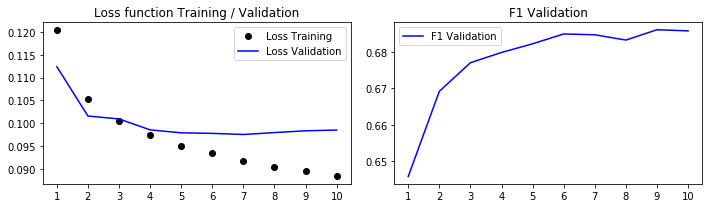

Split: 1 


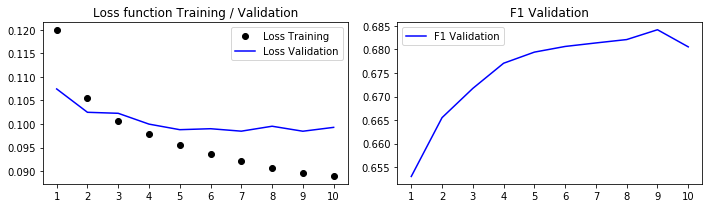

Split: 2 


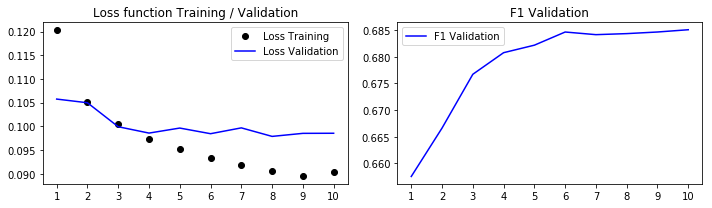

In [25]:
for i in my_history_dict:
    
    print('Split: {} '.format(i))
    loss = my_history_dict[i].history['loss']
    val_loss = my_history_dict[i].history['val_loss']
    epochs = np.arange(1, len(loss) +1, 1) # x-axis

    # Plotting:
    f = plt.figure(figsize=(10,3))
    # plots loss
    f.add_subplot(1, 2, 1) # number of rows, number of columns,subplot you're currently on.
    plt.xticks(epochs)
    plt.plot(epochs, loss, 'bo', label='Loss Training', color = 'black')
    plt.plot(epochs, val_loss, 'b', label='Loss Validation')
    plt.title('Loss function Training / Validation')
    plt.legend()
 
    # plots f1 score
    f.add_subplot(1, 2, 2)
    best_val_f1s = my_metrics_dict[i].best_val_f1s
   # plt.figure()
    plt.xticks(epochs)
    plt.plot(epochs, best_val_f1s, 'b', label='F1 Validation')
    plt.title('F1 Validation')
    plt.legend()
    
    #plt.subplots_adjust(wspace=0.30) # width reserved for blank space between subplots
    f.tight_layout()
    plt.show()

In [26]:
train_and_eval= time.time()
duration_train_and_eval = train_and_eval - end_embeddings
print(duration_train_and_eval)
runtime_dict['Modeling'] = round(duration_train_and_eval)

6571.772982597351


### 2. Evaluation of the kernel runtime

* especially time for model training, which is critical

In [27]:
import plotly.graph_objects as go
import pandas as pd

top_labels = ['Data Preparation', 'Embeddings', 'Modeling']

colors = ['rgba(38, 24, 74, 0.8)', 'rgba(71, 58, 131, 0.8)','rgba(122, 120, 168, 0.8)']

x_data = []
for phase, dur in runtime_dict.items():
    x_data.append(dur)
x_data = [x_data]

y_data = ['Runtime [s]']

fig = go.Figure()

for i in range(0, len(x_data[0])):
    for xd, yd in zip(x_data, y_data):
        fig.add_trace(go.Bar(
            x=[xd[i]], y=[yd],
            orientation='h',
            width = 0.4, # width of bars
            marker=dict(
                color=colors[i],
                line=dict(color='rgb(248, 248, 249)')
            )
        ))

fig.update_layout(
    xaxis=dict(
        showgrid=False,
        showline=False,
        showticklabels=True,
        zeroline=False,
        domain=[0.15, 1]
    ),
    yaxis=dict(
        showgrid=False,
        showline=False,
        showticklabels=False,
        zeroline=False,
    ),
    barmode='stack',
    paper_bgcolor='rgb(248, 248, 255)',
    plot_bgcolor='rgb(248, 248, 255)',
    margin=dict(l=120, r=10, t=140, b=40),
    showlegend=False,
)

annotations = []

for yd, xd in zip(y_data, x_data):
    # labeling the y-axis
    annotations.append(dict(xref='paper', yref='y',
                            x=0.14, y=yd,
                            xanchor='right',
                            text=str(yd),
                            font=dict(family='Arial', size=14,
                                      color='rgb(67, 67, 67)'),
                            showarrow=False, align='right'))
    # labeling the first percentage of each bar (x_axis)
    annotations.append(dict(xref='x', yref='y',
                            x=xd[0] / 2, y=yd,
                            text=str(xd[0]),
                            font=dict(family='Arial', size=14,
                                      color='rgb(248, 248, 255)'),
                            showarrow=False))
    # labeling the first Likert scale (on the top)
    if yd == y_data[-1]:
        annotations.append(dict(xref='x', yref='paper',
                                x=xd[0] / 2, y=1.1,
                                text=top_labels[0],
                                font=dict(family='Arial', size=14,
                                          color='rgb(67, 67, 67)'),
                                showarrow=False))
    space = xd[0]
    for i in range(1, len(xd)):
            # labeling the rest of percentages for each bar (x_axis)
            annotations.append(dict(xref='x', yref='y',
                                    x=space + (xd[i]/2), y=yd,
                                    text=str(xd[i]),
                                    font=dict(family='Arial', size=14,
                                              color='rgb(248, 248, 255)'),
                                    showarrow=False))
            # labeling the Likert scale
            if yd == y_data[-1]:
                annotations.append(dict(xref='x', yref='paper',
                                        x=space + (xd[i]/2), y=1.1,
                                        text=top_labels[i],
                                        font=dict(family='Arial', size=14,
                                                  color='rgb(67, 67, 67)'),
                                        showarrow=False))
            space += xd[i]

fig.update_layout(annotations=annotations)

fig.show()

# Submission (Prediction)

* 1 - This section contains loading of test data and applicatin of preprocessing function
* 2 - This section contains the extraction of question texts and their conversion in integer sequences
* 3 - This section contains the model prediction to create the submission file
* 4 - This section saved the submission file as kernel output to get a score within the competition

### 1. Load data and apply preprocessing function

In [28]:
# Load unlabeled test dataset
test = pd.read_csv("/kaggle/input/quora-insincere-questions-classification/test.csv")
test.head(5)

,qid,question_text
0,0000163e3ea7c7a74cd7,Why do so many women become so rude and arrogant when they get just a little bit of wealth and power?
1,00002bd4fb5d505b9161,When should I apply for RV college of engineering and BMS college of engineering? Should I wait for the COMEDK result or am I supposed to apply before the result?
2,00007756b4a147d2b0b3,What is it really like to be a nurse practitioner?
3,000086e4b7e1c7146103,Who are entrepreneurs?
4,0000c4c3fbe8785a3090,Is education really making good people nowadays?


In [29]:
# Preprocessing
os.system('echo applying preprocessing functions to testset..')
test["question_text"] = test["question_text"].fillna(" ").apply(lambda x: preprocessing(x))
os.system('echo prepocessing testset done')

0

### 2. Extract questions from dataframe and create integer sequences

* integer sequences are created with the tokenizer which contains the word_index (=vocab)

In [30]:
# Extract questions from test dataframe
X_test = test.loc[:, 'question_text'].values

# Transforma questions to integer sequences
sequences = tokenizer.texts_to_sequences(X_test)
padded_seq_test = pad_sequences(sequences, maxlen=maxlen)  

### 3. Model prediction

* model predicts a class probability
* class probability is converted to distinct class labels via a threshold, resulting in question labeling as
         0 (insincere questions) or 1 (sincere questions)
* the optimal threshold was examined during model training (Modeling -  section 3)

In [31]:
# Model Prediction
preds = model.predict(padded_seq_test, batch_size = 512, verbose = 1)
final_preds = preds

# Create a submission dataframe and append relevant columns
submission = pd.DataFrame()
submission['qid'] = test['qid'].values
submission['prediction'] = (final_preds > 0.38).astype(int) # round sigmoid results to integers

# Do test and my submission Dataframe have the same length?
if len(submission) == len(test):
    print("Submission dataframe has the same length as test dataframe with shape:{}".format(submission.shape))
else:
    print("Something is wrong!")
    
submission.head()

375806/375806 [==============================] - 21s 55us/step
Submission dataframe has the same length as test dataframe with shape:(375806, 2)


,qid,prediction
0,0000163e3ea7c7a74cd7,1
1,00002bd4fb5d505b9161,0
2,00007756b4a147d2b0b3,0
3,000086e4b7e1c7146103,0
4,0000c4c3fbe8785a3090,0


### 3. Submission of predictions

* submission file is saved as kernel output
* based on the submission file the competiton F1-score is calculated

In [32]:
# Submission File as Output
submission.to_csv('submission.csv', index = False)